## Day 24 - Virgo Detector Training Preparation

In [ ]:
# !git clone https://github.com/gablabc/PyFD.git
# !git clone https://git.ligo.org/virgo/virgoapp/PythonVirgoTools.git

In [ ]:
!pip install PyFd
!pip install PyCm

In [ ]:
from PythonVirgoTools import *
# from PyFd import *
# from PyCm import *

In [ ]:
import gwpy
import numpy
import scipy
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import sys
import os

# Caminho absoluto para a pasta "src" dentro de PythonVirgoTools
src_path = os.path.abspath("PythonVirgoTools/src")
# PyFD_path = os.path.abspath("../../../PyFd")

if src_path not in sys.path:
    sys.path.append(src_path)
    
# if PyFD_path not in sys.path:
#     sys.path.append(PyFD_path)

In [ ]:
from virgotools import getChannel
import matplotlib.pyplot as plt
# Some (useless) customizations

plt.rcParams.update({
 'axes.labelsize': 9,
 'xtick.labelsize': 9,
 'ytick.labelsize': 9,
 'grid.color': 'gray',
 'font.size': 9,
 'font.family': 'serif',
 'savefig.dpi': 180,
 'legend.fontsize': 9,
 'grid.alpha': .3,
 "mathtext.fontset": "cm",
})

# The following is a "magic function" that select the backend of
# iPython. It will results later:
%matplotlib inline

### isolar o arquivo frame_lib.py e importar diretamente

In [ ]:
pip install pythonvirgotools

In [ ]:
import importlib.util
import sys
import os

# Caminho para frame_lib.py
frame_path = os.path.abspath("PythonVirgoTools/src/virgotools/frame_lib.py")

spec = importlib.util.spec_from_file_location("frame_lib", frame_path)
frame_lib = importlib.util.module_from_spec(spec)
sys.modules["frame_lib"] = frame_lib
spec.loader.exec_module(frame_lib)

# Agora use
FrV = frame_lib.getChannel("V1:Hrec_hoft_16384Hz", 1414713610, 10)

In [ ]:
from virgotools.frame_lib import getChannel

In [ ]:
gps = 1414713610
ch = "V1:Hrec_hoft_16384Hz"
FrV = getChannel(ch, gps, 10)

### Day 25 - Gravity Spy tutorial 1: how can we classify a glitch?

author: Melissa Lopez

email: m.lopez@uu.nl

Let's install some packages first.

In [ ]:
%matplotlib inline

In [ ]:
!pip uninstall -y tensorflow numpy jax jaxlib
!pip install numpy==1.23.5 tensorflow==2.15 gwpy==3.0.12 gwtrigfind panoptes_client

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import sys
!{sys.executable} -m pip install tensorflow==2.15

!{sys.executable} -m pip install numpy==1.23.5 gwpy==3.0.12 gwtrigfind panoptes_client

In [1]:
import tensorflow as tf
import numpy as np
import gwpy
import gwtrigfind
import panoptes_client

print("TensorFlow:", tf.__version__)


TensorFlow: 2.15.0


In [3]:
!git clone https://github.com/MelissaLP/GravitySpy.git

fatal: destination path 'GravitySpy' already exists and is not an empty directory.


In [5]:
from gwpy.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import requests
import sys

In [17]:
#FIXME: your path to your Gravity Spy repo
path_to_repo = "GravitySpy"
sys.path.insert(0, path_to_repo)
from gravityspy.classify import classify
from gravityspy.utils import utils
from gravityspy.plot import plot_qtransform
warnings.filterwarnings('ignore')

In this tutorial we will fetch real GW data and learn how to run [`Gravity Spy` pipeline](https://iopscience.iop.org/article/10.1088/1361-6382/aa5cea). Gravity Spy is a project that uses crowdsourcing and machine learning to classify glitches in LIGO data, helping identify and eliminate noise, improving gravitational-wave observations by combining human and algorithmic classification methods.

In Zenodo we can find [`Gravity Spy` datasets](https://zenodo.org/records/5649212) that contains `Gravity Spy` classifications of LIGO glitches from observing runs O1, O2, and O3 (split into O3a and O3b). It includes noise events identified by the [`Omicron` trigger pipeline](https://www.sciencedirect.com/science/article/pii/S2352711020303332), with signal-to-noise ratios above 7.5 and frequencies between 10 Hz and 2048 Hz, using Omega scans.

In [21]:
# URL of the CSV file
url = "https://zenodo.org/records/5649212/files/H1_O3a.csv?download=1"
file_to_store = './H1_O3a.csv' # Fix this to your desired path and name
# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Write the content of the response to a local CSV file
    with open(file_to_store, "wb") as file:
        file.write(response.content)

    glitches = pd.read_csv(file_to_store) # if succesful we load it
    print("File downloaded successfully.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded successfully.


**Exercise 1:** Explore the glitch data set.
- Visualize the columns
- How many unique glitches do we have?
- Plot a histogram of `ml_confidence`

What can you say about `ml_confidence`?

In [91]:
glitches['event_time'][0]

1238303043.3125

This is a brief explanation of these columns:

- **event_time**: Time of the event detection.
- **ifo**: Interferometer name (e.g., LIGO Hanford is H1).
- **peak_time**: Time of the peak signal.
- **peak_time_ns**: Peak signal time in nanoseconds.
- **start_time**: Start time of the event.
- **start_time_ns**: Start time in nanoseconds.
- **duration**: Duration of the glitch.
- **peak_frequency**: Peak frequency of the glitch.
- **central_freq**: Central frequency of the glitch.
- **bandwidth**: Bandwidth of the glitch.
- **channel**: The data channel where the glitch was detected.
- **amplitude**: Amplitude of the glitch signal.
- **snr**: Signal-to-noise ratio of the event.
- **q_value**: Quality factor of the glitch.
- **gravityspy_id**: Unique identifier for the gravity spy classification.

Then there is a bunch of glitch names such as:

**'1400Ripples', '1080Lines', 'Air_Compressor', 'Blip', 'Chirp',
       'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation',
       'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch',
       'None_of_the_Above', 'Paired_Doves', 'Power_Line', 'Repeating_Blips',
       'Scattered_Light', 'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line',
       'Whistle'**

Last but not least, we have the following columns:

- **ml_label**: The label assigned by the machine learning model.
- **ml_confidence**: Confidence score for the machine learning model's classification.
- **url1, url2, url3, url4**: URLs linking to additional resources or data related to the event.

We will select the first glitch to reclasify it with `Gravity Spy`. For this we select `peak_time` as this will correspond roughly to the center of the glitch.

**Exercise 2:** Get the `event_time` as the second glitch time combining `peak_time` and `peak_time_ns`. The `start` and `end` variables will be ± 20 s. We also need the detector information. In what `ifo` does glitch 2 happen?

In [158]:
j = 17 # second glitch

# 2 Low_Frequency_Burst     17 Koi_Fish
# 19 Extremely_Loud         23 Tomte
# 25 No_Glitch              29 Blip
# 35 Low_Frequency_Lines

event_time = glitches.iloc[j]['peak_time'] + 10**(-9)*glitches.iloc[j]['peak_time_ns']
start = event_time - 20 # we load 20s before and after to avoid border effects
end = event_time + 20

In [160]:
ifo = glitches.iloc[0]['ifo'] # need to fetch data 
channel_name = f'{ifo}:GDS-CALIB_STRAIN' # to use later
# Now we call the data with gpwy
glitch_series = TimeSeries.fetch_open_data(ifo, start, end)

Using the previous information we fetch the data.

With `glitch_series` we can already classify the glitch using `classify` function. However, I would like first to explain what is happening under the hood.

`Gravity Spy` is a convolutional neural network, which means that it processes images, which in GW context implies time-frequency representations known as spectrograms. The configuration of `Gravity Spy` to generate these spectrograms (and others) is encoded within `GravitySpyConfigFile`. So first we need to call this specific configuration.

In [166]:
config = utils.GravitySpyConfigFile()
plot_time_ranges = config.plot_time_ranges
plot_normalized_energy_range = config.plot_normalized_energy_range

- `config `: Creates an instance of the `GravitySpyConfigFile` class from the `utils` module, likely used for managing configuration settings.

- `plot_time_ranges`: defines time intervals for plotting or analysis.

- `plot_normalized_energy_range`: specifies a range for normalized energy values in plots or analysis, i.e. the z-axis of the spectrogram.

Now we can make the spectrograms using `make_q_scans` and plot them.

In [171]:
glitches.iloc[j]

event_time                                               1238404385.3457
ifo                                                                   H1
peak_time                                                     1238404385
peak_time_ns                                                   345702886
start_time                                                    1238404383
start_time_ns                                                  875000000
duration                                                           3.125
peak_frequency                                                 72.365562
central_freq                                                   3408.4104
bandwidth                                                    6787.849609
channel                                                 GDS-CALIB_STRAIN
amplitude                                                            0.0
snr                                                           287.920868
q_value                                            

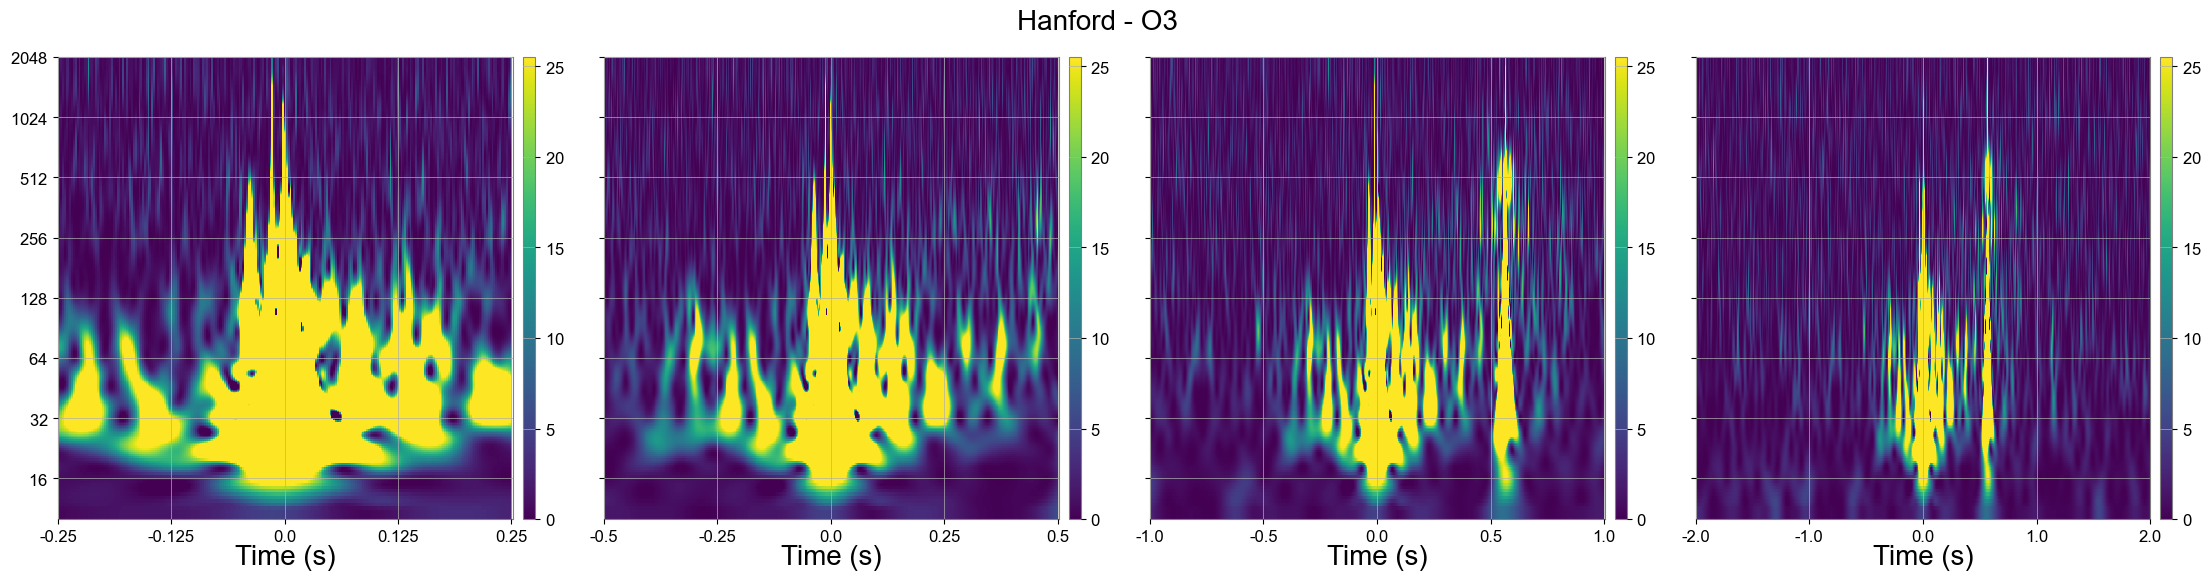

In [173]:
specsgrams, q_value = utils.make_q_scans(event_time=event_time,
                                         timeseries=glitch_series,
                                         config=config,
                                         channel_name=channel_name)

# ind_fig_all, super_fig = plot_qtransform(specsgrams,
_, super_fig = plot_qtransform(specsgrams,
                                         plot_normalized_energy_range,
                                         plot_time_ranges,
                                         ifo,
                                         event_time)
plt.close('all')
super_fig # this combines the 4 different time resolutions of Gravity Spy

`super_fig` is the visualization of what `Gravity Spy` is classifying. If we directly want to simply classify our glitch, we use `classify` function as seen below.

In [174]:
# I use Siddharth Soni's model but the repo has more models to try!
path_to_model = f'{path_to_repo}/models/sidd-cqg-paper-O3-model.h5'

results_glitch = classify(event_time=event_time,
                          channel_name=channel_name,
                          path_to_cnn=path_to_model,
                          timeseries=glitch_series)

In [181]:
results_glitch

1080Lines,1400Ripples,Air_Compressor,Blip,Blip_Low_Frequency,Chirp,Extremely_Loud,Fast_Scattering,Helix,Koi_Fish,Light_Modulation,Low_Frequency_Burst,Low_Frequency_Lines,No_Glitch,Paired_Doves,Power_Line,Repeating_Blips,Scattered_Light,Scratchy,Tomte,Violin_Mode,Wandering_Line,Whistle,Filename1,Filename2,Filename3,Filename4,gravityspy_id,ml_label,ml_confidence,q_value
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str49,str49,str49,str49,str20,str15,float32,float64
2.4309927e-08,3.6337222e-09,1.1695228e-10,1.4211444e-09,1.0991266e-09,1.7317393e-06,0.5354043,3.5890054e-05,9.410945e-06,0.46450588,1.08892074e-07,3.9296033e-10,5.4889506e-09,2.4978137e-09,1.1413458e-05,4.3970536e-10,3.470323e-07,1.8606574e-05,1.1474093e-05,2.0199295e-10,6.584574e-07,8.035028e-08,1.3588571e-08,plots\H1_1238404385.345702887_spectrogram_4.0.png,plots\H1_1238404385.345702887_spectrogram_1.0.png,plots\H1_1238404385.345702887_spectrogram_2.0.png,plots\H1_1238404385.345702887_spectrogram_4.0.png,1238404385.345702887,Extremely_Loud,0.5354043,5.65685424949238
6.815734e-07,1.1526361e-06,8.621628e-08,2.0165015e-05,1.3545989e-07,1.4686894e-05,0.2564663,3.11897e-08,0.0003246697,0.0051386766,0.29945678,3.4716497e-06,3.729214e-06,8.979224e-05,1.741341e-07,1.0710902e-06,0.3550944,5.152586e-06,4.575043e-05,1.9963421e-08,7.7618635e-05,0.003533378,0.07972209,plots\L1_1238303043.312500000_spectrogram_4.0.png,plots\L1_1238303043.312500000_spectrogram_1.0.png,plots\L1_1238303043.312500000_spectrogram_2.0.png,plots\L1_1238303043.312500000_spectrogram_4.0.png,1238303043.312500000,Repeating_Blips,0.3550944,5.65685424949238
0.0012007785,0.084367655,0.0060820216,0.0024775178,0.007002837,0.00068929995,0.0034158246,0.024784297,0.009603302,0.0017286529,0.0034927824,0.011432474,0.014181043,0.75218815,0.005426865,0.0012780455,0.0066165943,0.020964092,0.015435927,0.0004862449,0.023634749,0.0010689765,0.002441884,plots\L1_1238353000.000000000_spectrogram_4.0.png,plots\L1_1238353000.000000000_spectrogram_1.0.png,plots\L1_1238353000.000000000_spectrogram_2.0.png,plots\L1_1238353000.000000000_spectrogram_4.0.png,1238353000.000000000,No_Glitch,0.75218815,5.65685424949238


It is relevant to note that folder named `plots` was created to classify our glitch. If you classify multiple glitches `Gravity Spy` will classify _all_ images within forming a table.

**Exercise 3:** What glitch did we classify? How confident are we? Try to classify the third glitch instead.